In [1]:
# Load the dataset 
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split



In [2]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

In [3]:
movies.head()

,movie_id,movie_title,movie_genres_str
0,1,Toy Story (1995),"['Adventure', 'Animation', ""Children's""]"
1,2,GoldenEye (1995),"['unknown', 'Action', 'Thriller']"
2,3,Four Rooms (1995),['Thriller']
3,4,Get Shorty (1995),"['unknown', ""Children's"", 'Documentary']"
4,5,Copycat (1995),"['Comedy', 'Documentary', 'Thriller']"


In [4]:
ratings.head()

,movie_id,user_id,user_rating
0,357,138,4.0
1,709,92,2.0
2,412,301,4.0
3,56,60,4.0
4,895,197,3.0


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   movie_id          1682 non-null   int64 
 1   movie_title       1682 non-null   object
 2   movie_genres_str  1682 non-null   object
dtypes: int64(1), object(2)
memory usage: 39.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movie_id     100000 non-null  int64  
 1   user_id      100000 non-null  int64  
 2   user_rating  100000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [7]:
user_size = ratings['user_id'].nunique()
movie_size = ratings['movie_id'].nunique()

print(user_size)
print(movie_size)

943
1682


Split dataset

In [8]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

In [9]:
print("Train Size", train.shape)
print("Test Size", test.shape)

Train Size (80000, 3)
Test Size (20000, 3)


In [10]:
# Build Model System recommendation
EMBEDDING_SIZE = 50

# Define model using Functional API 
movie_input = tf.keras.layers.Input(shape=[1])
user_input = tf.keras.layers.Input(shape=[1])

# Embedding layers
movie_embedding = tf.keras.layers.Embedding(movie_size + 1, EMBEDDING_SIZE)(movie_input)
user_embedding = tf.keras.layers.Embedding(user_size + 1, EMBEDDING_SIZE)(user_input)

# flatten the embeddings
movie_flat = tf.keras.layers.Flatten()(movie_embedding)
user_flat = tf.keras.layers.Flatten()(user_embedding)

# # layers Densen
# Dense_movie = tf.keras.layers.Dense(8, activation='relu')(movie_flat)
# Dense_ratings = tf.keras.layers.Dense(8, activation='relu')(user_flat)

# layer output
# output = tf.keras.layers.Dot(1)([Dense_movie, Dense_ratings])
output = tf.keras.layers.Dot(1)([movie_flat, user_flat])

# The Model 
model = tf.keras.models.Model(inputs=[movie_input, user_input], outputs=[output])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        84150       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        47200       ['input_2[0][0]']                
                                                                                              

In [11]:
# compile the model 
model.compile(loss='mae', optimizer='adam')

In [12]:
train.head()

,movie_id,user_id,user_rating
75220,1016,109,5.0
48955,64,316,4.0
44966,89,200,5.0
13568,174,109,5.0
92727,204,788,3.0


In [13]:
# train the model 
history = model.fit(x=[train['movie_id'], train['user_id']],
          y=train['user_rating'],
          epochs=20,
          batch_size=128,
          validation_data=([test['movie_id'], test['user_id']], test['user_rating'])
          )

Epoch 1/20
625/625 [==============================] - 7s 8ms/step - loss: 3.1031 - val_loss: 1.5107
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 0.9909 - val_loss: 0.8146
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7721 - val_loss: 0.7627
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7386 - val_loss: 0.7497
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7210 - val_loss: 0.7415
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7081 - val_loss: 0.7358
Epoch 7/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6961 - val_loss: 0.7339
Epoch 8/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6855 - val_loss: 0.7309
Epoch 9/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6748 - val_loss: 0.7297
Epoch 10/20
625/625 [==============================] - 4s 6ms/step - loss: 0.6637 - val_loss: 0.7282

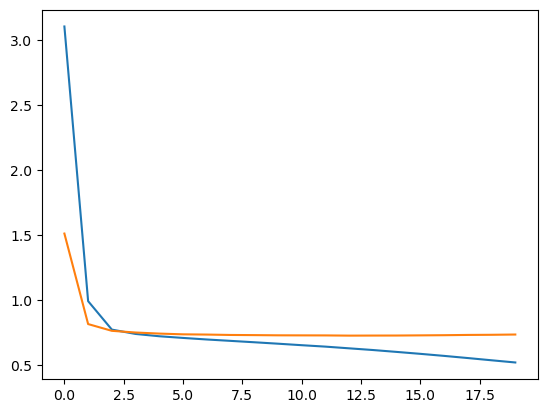

In [14]:
import matplotlib.pyplot as plt

losses = pd.DataFrame(history.history)
plt.plot(losses)

In [15]:
model.evaluate([test.movie_id, test.user_id], test.user_rating)

625/625 [==============================] - 3s 4ms/step - loss: 0.7343


0.7342984080314636

In [17]:
# get recommendation

import numpy as np
import matplotlib.pyplot as plt

def get_recommendations(user_id, movies, model):
    movies = movies.copy()
    user_ids = np.array([user_id] * len(movies))
    results = model([movies['movie_id'].values, user_ids]).numpy().reshape(-1)

    movies['predicted_rating'] = pd.Series(results)
    movies = movies.sort_values('predicted_rating', ascending=False)

    print(f"Recommendation for user{user_ids}")
    return movies

In [18]:
get_recommendations(5, movies, model)

Recommendation for user[5 5 5 ... 5 5 5]


,movie_id,movie_title,movie_genres_str,predicted_rating
49,50,Star Wars (1977),"['unknown', 'Action', 'Romance', 'Sci-Fi', 'We...",4.939991
180,181,Return of the Jedi (1983),"['unknown', 'Action', 'Romance', 'Sci-Fi', 'We...",4.850642
194,195,"Terminator, The (1984)","['unknown', 'Sci-Fi', 'Thriller']",4.825572
99,100,Fargo (1996),"['Comedy', 'Documentary', 'Thriller']",4.768197
172,173,"Princess Bride, The (1987)","['unknown', 'Action', ""Children's"", 'Romance']",4.755917
...,...,...,...,...
1129,1130,Jupiter's Wife (1994),['Crime'],-0.089530
1667,1668,Wedding Bell Blues (1996),"[""Children's""]",-0.111017
1677,1678,Mat' i syn (1997),['Documentary'],-0.120731
1515,1516,"Wedding Gift, The (1994)",['Documentary'],-0.194044


In [19]:
model.save('model.h5')

In [21]:
def get_embedding(movies, model):
    vectors = model.layers[2](movies['movie_id'].values).numpy()
    vectors = pd.DataFrame(vectors)
    vectors.to_csv('vectors.tsv', sep='\t', header=False)

    movies.to_csv('meta.tsv', sep='\t')

get_embedding(movies, model)